<a href="https://colab.research.google.com/github/dani2442/2026-Hybrid-Signal-Learning/blob/helon/BAB_NODE_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAB Dataset: Linear & Nonlinear Models

Organized training and simulation for linear, Stribeck, and black-box models.

In [1]:
!pip install torchdiffeq git+https://github.com/helonayala/bab_datasets.git
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import bab_datasets as nod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Cloning https://github.com/helonayala/bab_datasets.git to /tmp/pip-req-build-c3o9w9a9
  Running command git clone --filter=blob:none --quiet https://github.com/helonayala/bab_datasets.git /tmp/pip-req-build-c3o9w9a9
  Resolved https://github.com/helonayala/bab_datasets.git to commit cf60b6ee8d7fb1fa448705848261ad490bfeed6d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bab_datasets: filename=bab_datasets-0.1.0-py3-none-any.whl size=13415 sha256=0dbe634d5186734ecea8d5a69a95cbe0896ac6ad35944534ac429ad1bae5d4d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-94rngudl/wheels/23/a0/ce/e7a4541a3bb5447c58417ab1f537ee233f610bbcfb1784d848
Successfully built bab_datasets
Using device: cuda


## 1) Protocol + Explicit Train/Test Split


In [2]:
velMethod = "central"
PROTOCOL_MODE = "split_50_50"  # "split_50_50" or "classic_train_test"
TRAIN_DATASETS_CLASSIC = ["multisine_05"]
resample_factor = 50

# Load all preprocessed datasets once (explicitly reused for train/test protocol)
datasets_cache = {}
all_datasets = nod.list_experiments()
for ds_name in all_datasets:
    data_ds = nod.load_experiment(
        ds_name,
        preprocess=True,
        plot=False,
        end_idx=None,
        resample_factor=resample_factor,
        zoom_last_n=200,
        y_dot_method=velMethod,
    )
    u_ds, y_ds, y_ref_ds, y_dot_ds = data_ds
    Ts_ds = data_ds.sampling_time
    y_sim_ds = np.column_stack([y_ds, y_dot_ds])
    datasets_cache[ds_name] = {
        "u": u_ds,
        "y": y_ds,
        "y_ref": y_ref_ds,
        "y_dot": y_dot_ds,
        "y_sim": y_sim_ds,
        "Ts": Ts_ds,
        "N": len(u_ds),
    }

# Build explicit train/test index sets per dataset
core_datasets = [d for d in all_datasets if ("multisine" in d or "random_steps" in d)]
external_datasets = [d for d in all_datasets if d not in core_datasets]

split_map = {}
for ds_name in all_datasets:
    N = datasets_cache[ds_name]["N"]
    if PROTOCOL_MODE == "split_50_50":
        if ds_name in core_datasets:
            mid = N // 2
            split_map[ds_name] = {
                "train_idx": np.arange(0, mid, dtype=int),
                "test_idx": np.arange(mid, N, dtype=int),
            }
        else:
            split_map[ds_name] = {
                "train_idx": np.array([], dtype=int),
                "test_idx": np.arange(0, N, dtype=int),
            }
    elif PROTOCOL_MODE == "classic_train_test":
        if ds_name in TRAIN_DATASETS_CLASSIC:
            split_map[ds_name] = {
                "train_idx": np.arange(0, N, dtype=int),
                "test_idx": np.array([], dtype=int),
            }
        else:
            split_map[ds_name] = {
                "train_idx": np.array([], dtype=int),
                "test_idx": np.arange(0, N, dtype=int),
            }
    else:
        raise ValueError(f"Unknown PROTOCOL_MODE: {PROTOCOL_MODE}")

# Build explicit training arrays by concatenating only training partitions
train_blocks_u = []
train_blocks_y = []
train_block_meta = []
Ts_values = []
for ds_name in all_datasets:
    idx = split_map[ds_name]["train_idx"]
    if len(idx) == 0:
        continue
    cache = datasets_cache[ds_name]
    train_blocks_u.append(cache["u"][idx])
    train_blocks_y.append(cache["y_sim"][idx])
    train_block_meta.append((ds_name, len(idx)))
    Ts_values.append(cache["Ts"])

if len(train_blocks_u) == 0:
    raise RuntimeError("No training samples selected by the current protocol.")

# Check sampling time consistency before concatenation
Ts = Ts_values[0]
if not np.allclose(Ts_values, Ts, rtol=0, atol=1e-12):
    raise RuntimeError(f"Inconsistent Ts across training datasets: {Ts_values}")

u = np.concatenate(train_blocks_u, axis=0)
y_sim = np.concatenate(train_blocks_y, axis=0)
y = y_sim[:, 0]
y_dot = y_sim[:, 1]
y_ref = np.full_like(y, np.nan)
t = np.arange(len(u)) * Ts

# Segment boundaries in concatenated training vector (to avoid k-step windows crossing dataset boundaries)
train_segments = []
cursor = 0
for ds_name, seg_len in train_block_meta:
    train_segments.append((ds_name, cursor, cursor + seg_len))
    cursor += seg_len

print(f"Protocol mode: {PROTOCOL_MODE}")
print(f"Core datasets: {core_datasets}")
print(f"External datasets (test-only in split_50_50): {external_datasets}")
print(f"Training datasets/segments: {train_block_meta}")
print(f"Total training samples: {len(u)}")


Protocol mode: split_50_50
Core datasets: ['multisine_05', 'multisine_06', 'random_steps_01', 'random_steps_02', 'random_steps_03', 'random_steps_04']
External datasets (test-only in split_50_50): ['rampa_negativa', 'rampa_positiva', 'swept_sine']
Training datasets/segments: [('multisine_05', 550), ('multisine_06', 550), ('random_steps_01', 550), ('random_steps_02', 550), ('random_steps_03', 550), ('random_steps_04', 550)]
Total training samples: 3300


## 2) Tensor Prep (From Explicit Training Split)


In [3]:
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
u_tensor = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)
y_tensor = torch.tensor(y_sim, dtype=torch.float32).to(device)

# Precompute valid k-step start indices so minibatches never cross concatenated segment boundaries
K_STEPS = 20
valid_train_start_idx = []
for _, s0, s1 in train_segments:
    if (s1 - s0) > K_STEPS:
        valid_train_start_idx.extend(range(s0, s1 - K_STEPS))
valid_train_start_idx = np.asarray(valid_train_start_idx, dtype=int)

if len(valid_train_start_idx) == 0:
    raise RuntimeError("No valid k-step windows found in training split. Decrease K_STEPS or increase train split size.")

print(f"Tensor shapes -> t: {tuple(t_tensor.shape)}, u: {tuple(u_tensor.shape)}, y: {tuple(y_tensor.shape)}")
print(f"Valid train starts: {len(valid_train_start_idx)}")


Tensor shapes -> t: (3300,), u: (3300, 1), y: (3300, 2)
Valid train starts: 3180


## 3) Model Definitions

In [4]:
class LinearPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        return J, R, K, self.delta, Tau

    def forward(self, t, x):
        J, R, K, delta, Tau = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        thdd = (Tau * u_t - R * thd - K * (th + delta)) / J
        return torch.cat([thd, thdd], dim=1)


class StribeckPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) + F_stribeck = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.log_Fc = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_Fs = nn.Parameter(torch.tensor(np.log(0.2), dtype=torch.float32))
        self.log_vs = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_b = nn.Parameter(torch.tensor(np.log(0.01), dtype=torch.float32))

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        Fc = torch.exp(self.log_Fc)
        Fs = torch.exp(self.log_Fs)
        vs = torch.exp(self.log_vs)
        b = torch.exp(self.log_b)
        return J, R, K, self.delta, Tau, Fc, Fs, vs, b

    def forward(self, t, x):
        J, R, K, delta, Tau, Fc, Fs, vs, b = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        sgn = torch.tanh(thd / 1e-3)
        F_str = (Fc + (Fs - Fc) * torch.exp(-(thd / vs) ** 2)) * sgn + b * thd
        thdd = (Tau * u_t - R * thd - K * (th + delta) - F_str) / J
        return torch.cat([thd, thdd], dim=1)


class BlackBoxODE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 2)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        nn_input = torch.cat([x, u_t], dim=1)
        return self.net(nn_input)


class HybridJointODE(nn.Module):
    # thdd = physics(theta, theta_dot, u) + NN residual
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def _interp_u(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        return u1 + alpha * (u2 - u1)

    def forward(self, t, x):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)

        u_t = self._interp_u(t, x)
        th, thd = x[:, 0:1], x[:, 1:2]

        thdd_phys = (Tau * u_t - R * thd - K * (th + self.delta)) / J
        thdd_res = self.net(torch.cat([th, thd, u_t], dim=1))
        thdd = thdd_phys + thdd_res
        return torch.cat([thd, thdd], dim=1)


class HybridFrozenPhysODE(nn.Module):
    # thdd = frozen physics(theta, theta_dot, u) + NN residual
    def __init__(self, phys_model, hidden_dim=128):
        super().__init__()
        J0, R0, K0, delta0, Tau0 = phys_model.get_params()
        self.register_buffer('J0', J0.detach().clone())
        self.register_buffer('R0', R0.detach().clone())
        self.register_buffer('K0', K0.detach().clone())
        self.register_buffer('delta0', delta0.detach().clone())
        self.register_buffer('Tau0', Tau0.detach().clone())

        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def _interp_u(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        return u1 + alpha * (u2 - u1)

    def forward(self, t, x):
        u_t = self._interp_u(t, x)
        th, thd = x[:, 0:1], x[:, 1:2]

        thdd_phys = (self.Tau0 * u_t - self.R0 * thd - self.K0 * (th + self.delta0)) / self.J0
        thdd_res = self.net(torch.cat([th, thd, u_t], dim=1))
        thdd = thdd_phys + thdd_res
        return torch.cat([thd, thdd], dim=1)


## 4) Training Helper

In [5]:
def train_model_obs(model, name, epochs=500, lr=0.02, obs_dim=2):
    print(f"--- Training {name} ---")
    model.to(device)
    model.u_series = u_tensor
    model.t_series = t_tensor

    optimizer = optim.Adam(model.parameters(), lr=lr)
    BATCH_SIZE = 128
    dt_local = (t_tensor[1] - t_tensor[0]).item()
    t_eval = torch.arange(0, K_STEPS * dt_local, dt_local, device=device)

    for epoch in range(epochs + 1):
        optimizer.zero_grad()

        # Sample only from valid indices to keep each k-step rollout inside one training segment
        start_idx = np.random.choice(valid_train_start_idx, size=BATCH_SIZE, replace=True)
        x0 = y_tensor[start_idx]
        model.batch_start_times = t_tensor[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')
        pred_obs = pred_state[..., :obs_dim]

        batch_targets = []
        for i in start_idx:
            batch_targets.append(y_tensor[i:i + K_STEPS])
        y_target = torch.stack(batch_targets, dim=1)  # [T, B, 2]

        # Position-only loss (theta), velocity is used only as IC
        pred_pos = pred_obs[..., 0:1]
        target_pos = y_target[..., 0:1]
        loss = torch.mean((pred_pos - target_pos) ** 2)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

    return model


## 5) Train Linear Model

In [6]:
lin_model = LinearPhysODE()
lin_model = train_model_obs(lin_model, "Linear Model", epochs=1000, lr=0.01)


--- Training Linear Model ---
Epoch 0 | Loss: 11.703551
Epoch 100 | Loss: 3.339943
Epoch 200 | Loss: 1.427427
Epoch 300 | Loss: 1.127665
Epoch 400 | Loss: 0.935262
Epoch 500 | Loss: 0.951323
Epoch 600 | Loss: 0.827561
Epoch 700 | Loss: 0.843408
Epoch 800 | Loss: 0.755601
Epoch 900 | Loss: 0.701072
Epoch 1000 | Loss: 0.653373


## 6) Train Stribeck Model

In [7]:
str_model = StribeckPhysODE()
str_model = train_model_obs(str_model, "Stribeck Model", epochs=1000, lr=0.01)


--- Training Stribeck Model ---
Epoch 0 | Loss: 9.497378
Epoch 100 | Loss: 3.679717
Epoch 200 | Loss: 2.301629
Epoch 300 | Loss: 1.908910
Epoch 400 | Loss: 1.720474
Epoch 500 | Loss: 2.238527
Epoch 600 | Loss: 2.323272
Epoch 700 | Loss: 1.893390
Epoch 800 | Loss: 2.427005
Epoch 900 | Loss: 2.970328
Epoch 1000 | Loss: 2.695999


## 7) Train Black-box Model

In [8]:
bb_model = BlackBoxODE(hidden_dim=128)
bb_model = train_model_obs(bb_model, "Black-Box Model", epochs=1000, lr=0.01)


--- Training Black-Box Model ---
Epoch 0 | Loss: 7.574547
Epoch 100 | Loss: 0.911901
Epoch 200 | Loss: 0.600367
Epoch 300 | Loss: 0.501631
Epoch 400 | Loss: 0.490375
Epoch 500 | Loss: 0.589322
Epoch 600 | Loss: 0.522933
Epoch 700 | Loss: 0.325293
Epoch 800 | Loss: 0.334189
Epoch 900 | Loss: 0.225478
Epoch 1000 | Loss: 0.350509


## 8) Train Hybrid Joint Model

In [9]:
hjoint_model = HybridJointODE(hidden_dim=128)
hjoint_model = train_model_obs(hjoint_model, "Hybrid-Joint Model", epochs=1000, lr=0.01)


--- Training Hybrid-Joint Model ---
Epoch 0 | Loss: 10.418387
Epoch 100 | Loss: 0.318994
Epoch 200 | Loss: 0.329263
Epoch 300 | Loss: 0.257287
Epoch 400 | Loss: 0.301294
Epoch 500 | Loss: 0.214943
Epoch 600 | Loss: 0.248604
Epoch 700 | Loss: 0.178170
Epoch 800 | Loss: 0.193171
Epoch 900 | Loss: 0.241182
Epoch 1000 | Loss: 0.183159


## 9) Train Hybrid Frozen-Physics Model

In [10]:
hfrozen_model = HybridFrozenPhysODE(lin_model, hidden_dim=128)
hfrozen_model = train_model_obs(hfrozen_model, "Hybrid-Frozen Model", epochs=1000, lr=0.01)


--- Training Hybrid-Frozen Model ---
Epoch 0 | Loss: 0.570364
Epoch 100 | Loss: 0.330763
Epoch 200 | Loss: 0.522277
Epoch 300 | Loss: 0.351068
Epoch 400 | Loss: 0.397564
Epoch 500 | Loss: 1.382003
Epoch 600 | Loss: 1.189966
Epoch 700 | Loss: 0.795694
Epoch 800 | Loss: 0.979477
Epoch 900 | Loss: 0.903864
Epoch 1000 | Loss: 0.912586


## 8) Simulate Linear Model

In [11]:
with torch.no_grad():
    lin_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_lin = odeint(lin_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 9) Simulate Stribeck Model

In [12]:
with torch.no_grad():
    str_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_str = odeint(str_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 10) Simulate Black-box Model

In [13]:
with torch.no_grad():
    bb_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_bb = odeint(bb_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 12) Simulate Hybrid Joint Model

In [14]:
with torch.no_grad():
    hjoint_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_hjoint = odeint(hjoint_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 13) Simulate Hybrid Frozen-Physics Model

In [15]:
with torch.no_grad():
    hfrozen_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_hfrozen = odeint(hfrozen_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 11) Comparison Plots

Metrics - Position
Model        RMSE      R2        FIT%
Linear       1.2534    0.6934   44.63   
Stribeck     1.9067    0.2904   15.76   
Black-box    1.9360    0.2685   14.47   
Hybrid-Joint 0.6799    0.9098   69.96   
Hybrid-Frozen 1.4841    0.5701   34.43   
Metrics - Velocity
Model        RMSE      R2        FIT%
Linear       4.1447    0.9352   74.54   
Stribeck     10.6953   0.5682   34.29   
Black-box    16.6572   -0.0473  -2.34   
Hybrid-Joint 4.4494    0.9253   72.66   
Hybrid-Frozen 5.0101    0.9053   69.22   


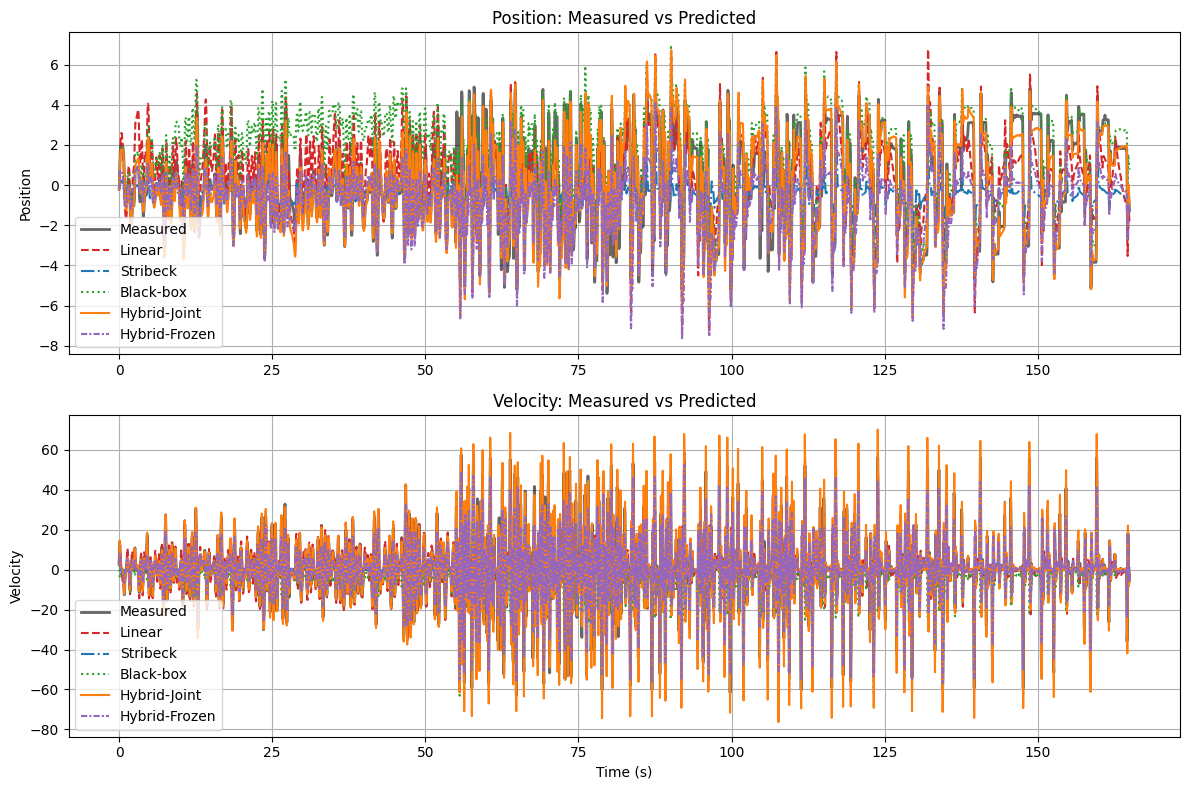

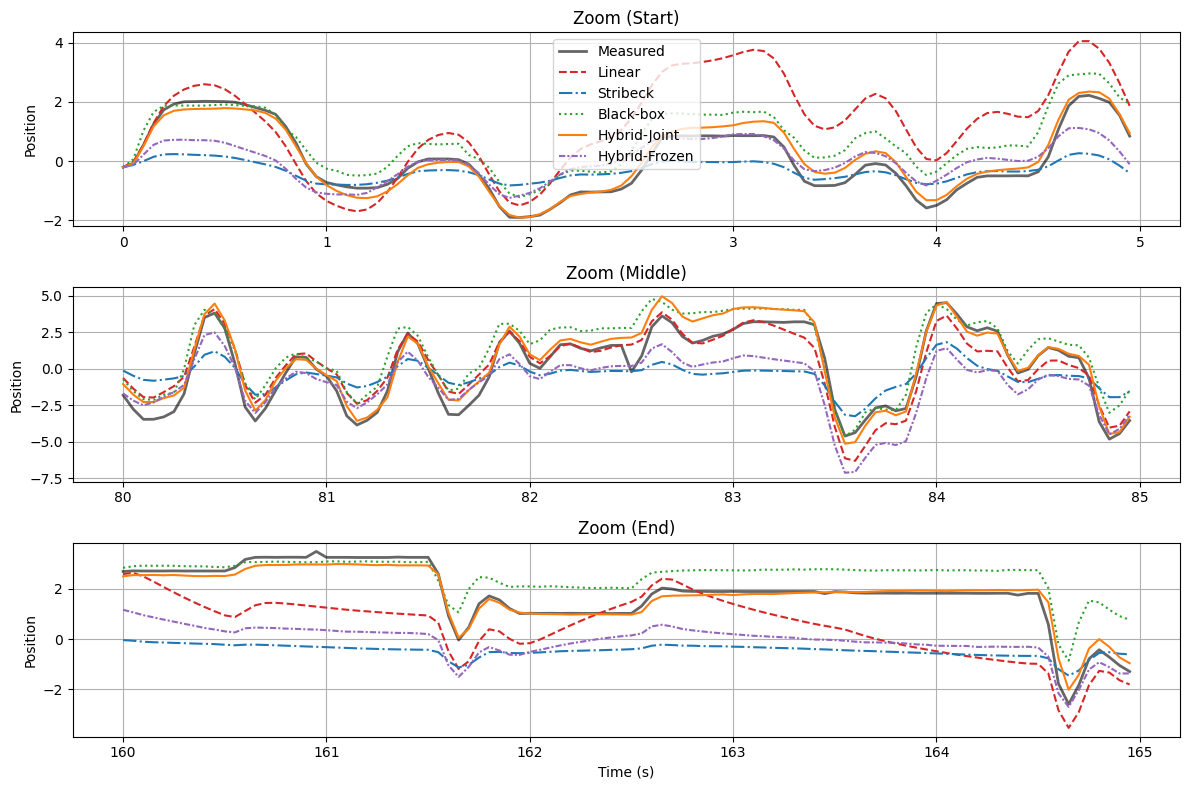

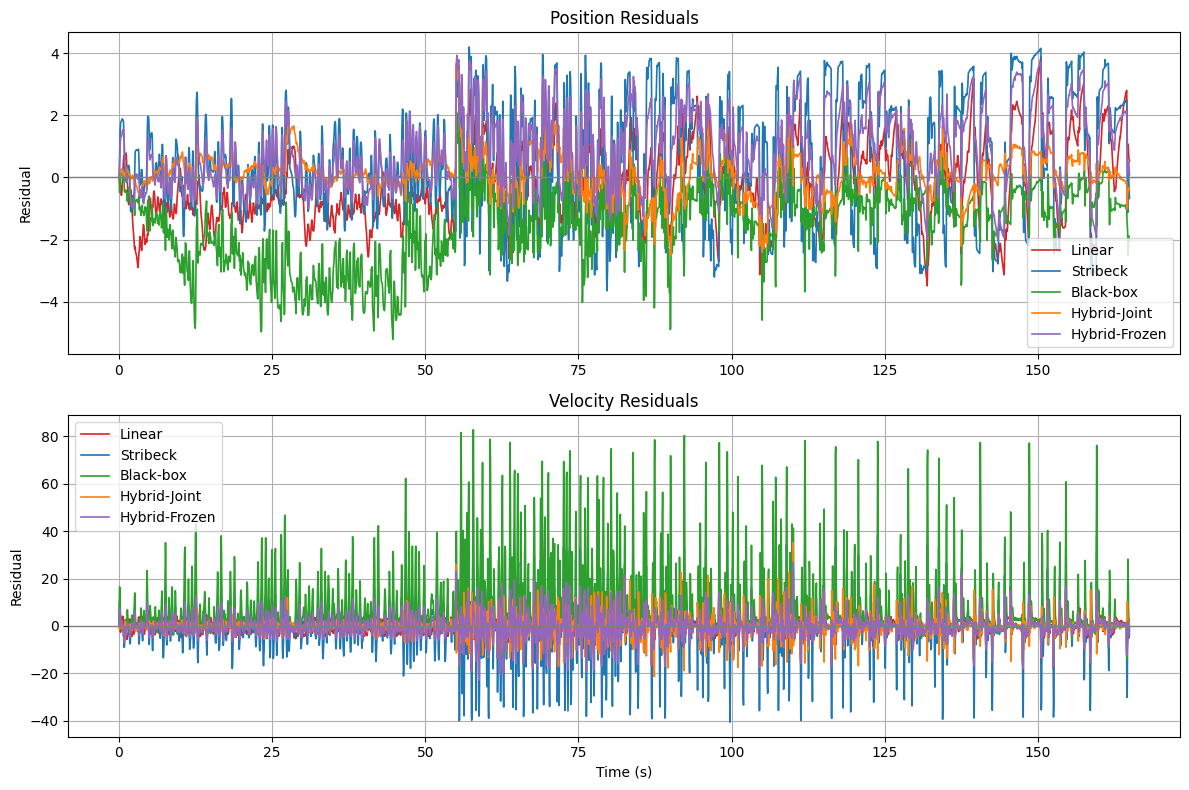

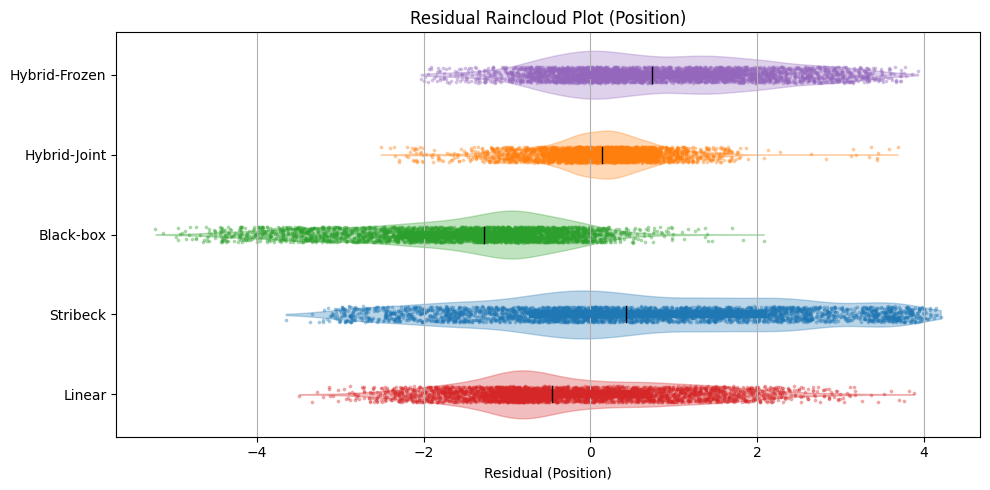

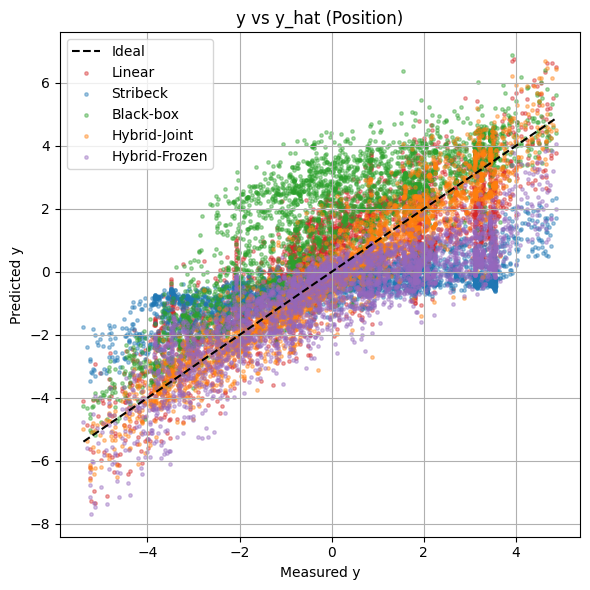

In [16]:
# Metrics and residuals for all models
models = {
    "Linear": pred_lin,
    "Stribeck": pred_str,
    "Black-box": pred_bb,
    "Hybrid-Joint": pred_hjoint,
    "Hybrid-Frozen": pred_hfrozen,
}
colors = {
    "Linear": "tab:red",
    "Stribeck": "tab:blue",
    "Black-box": "tab:green",
    "Hybrid-Joint": "tab:orange",
    "Hybrid-Frozen": "tab:purple",
}
styles = {
    "Linear": "--",
    "Stribeck": "-.",
    "Black-box": ":",
    "Hybrid-Joint": "-",
    "Hybrid-Frozen": (0, (3, 1, 1, 1)),
}

residuals = {}
metrics = {}
for name, pred in models.items():
    res_pos = y_sim[:, 0] - pred[:, 0]
    res_vel = y_sim[:, 1] - pred[:, 1]
    rmse_pos = np.sqrt(np.mean(res_pos**2))
    rmse_vel = np.sqrt(np.mean(res_vel**2))
    ss_res_pos = np.sum(res_pos**2)
    ss_tot_pos = np.sum((y_sim[:, 0] - np.mean(y_sim[:, 0]))**2)
    ss_res_vel = np.sum(res_vel**2)
    ss_tot_vel = np.sum((y_sim[:, 1] - np.mean(y_sim[:, 1]))**2)
    r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
    r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan
    fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_sim[:, 0] - np.mean(y_sim[:, 0])))
    fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_sim[:, 1] - np.mean(y_sim[:, 1])))
    residuals[name] = {"pos": res_pos, "vel": res_vel}
    metrics[name] = {"rmse_pos": rmse_pos, "rmse_vel": rmse_vel, "r2_pos": r2_pos, "r2_vel": r2_vel, "fit_pos": fit_pos, "fit_vel": fit_vel}

# Metrics tables
print("Metrics - Position")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_pos']:<9.4f} {m['r2_pos']:<8.4f} {m['fit_pos']:<8.2f}")

print("Metrics - Velocity")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_vel']:<9.4f} {m['r2_vel']:<8.4f} {m['fit_vel']:<8.2f}")

# Comparison plots (no metrics in titles)
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_sim[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.title("Position: Measured vs Predicted")

plt.subplot(2, 1, 2)
plt.plot(t, y_sim[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 1], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.title("Velocity: Measured vs Predicted")

plt.tight_layout()
plt.show()

# Zooms (position only)
win_sec = 5.0
win_n = int(win_sec / Ts)
starts = [0, max(0, (len(t) - win_n) // 2), max(0, len(t) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(12, 8))
for i, s in enumerate(starts):
    e = min(len(t), s + win_n)
    plt.subplot(3, 1, i + 1)
    plt.plot(t[s:e], y_sim[s:e, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
    for name, pred in models.items():
        plt.plot(t[s:e], pred[s:e, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
    plt.title(f"Zoom ({labels[i]})")
    plt.ylabel('Position')
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Residuals (all models)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for name in models.keys():
    plt.plot(t, residuals[name]['pos'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Position Residuals')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
for name in models.keys():
    plt.plot(t, residuals[name]['vel'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Velocity Residuals')
plt.ylabel('Residual')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Raincloud plot (position residuals)
from scipy.stats import gaussian_kde

labels = list(models.keys())
res_list = [residuals[name]['pos'] for name in labels]

plt.figure(figsize=(10, 5))
for i, (label, res) in enumerate(zip(labels, res_list)):
    res = res[np.isfinite(res)]
    kde = gaussian_kde(res)
    xs = np.linspace(np.min(res), np.max(res), 200)
    ys = kde(xs)
    ys = ys / ys.max() * 0.3
    plt.fill_between(xs, i + ys, i - ys, color=colors[label], alpha=0.3)
    q1, q2, q3 = np.percentile(res, [25, 50, 75])
    plt.plot([q1, q3], [i, i], color=colors[label], linewidth=6)
    plt.plot([q2, q2], [i-0.1, i+0.1], color='k', linewidth=1)
    jitter = (np.random.rand(len(res)) - 0.5) * 0.2
    plt.scatter(res, i + jitter, s=3, color=colors[label], alpha=0.3)

plt.yticks(range(len(labels)), labels)
plt.xlabel('Residual (Position)')
plt.title('Residual Raincloud Plot (Position)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# y vs yhat (position)
plt.figure(figsize=(6, 6))
plt.plot([y_sim[:,0].min(), y_sim[:,0].max()], [y_sim[:,0].min(), y_sim[:,0].max()], 'k--', label='Ideal')
for name, pred in models.items():
    plt.scatter(y_sim[:,0], pred[:,0], s=6, alpha=0.4, color=colors[name], label=name)
plt.xlabel('Measured y')
plt.ylabel('Predicted y')
plt.title('y vs y_hat (Position)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12) Diagnostics (Position)

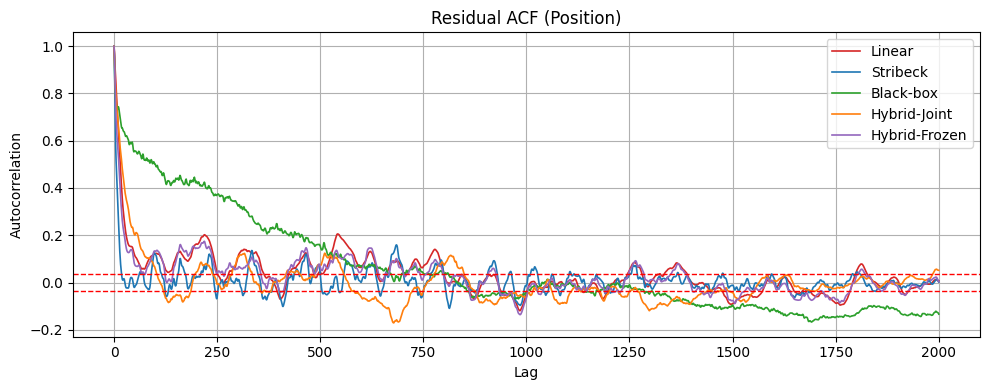

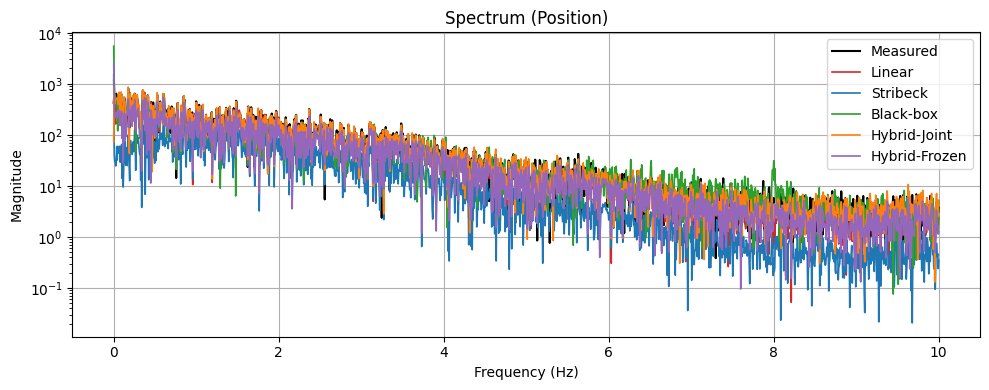

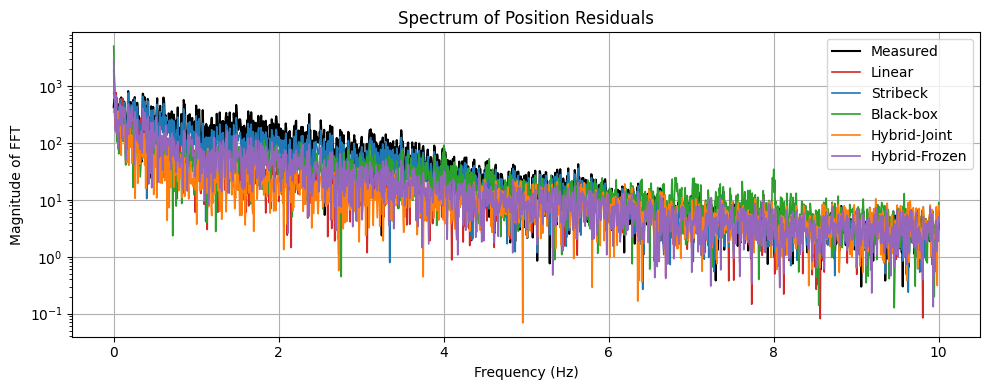

In [17]:
# Residual ACF (position) for all models
N = len(t)
max_lag = min(2000, N - 1)
conf = 1.96 / np.sqrt(N)

plt.figure(figsize=(10, 4))
for name in models.keys():
    res = residuals[name]['pos'] - np.mean(residuals[name]['pos'])
    acf = np.correlate(res, res, mode='full')
    acf = acf[N-1:N+max_lag] / acf[N-1]
    plt.plot(np.arange(0, max_lag+1), acf, color=colors[name], linewidth=1.2, label=name)

plt.axhline(conf, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf, color='red', linestyle='--', linewidth=1)
plt.title('Residual ACF (Position)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum: measured vs predictions (position)
freqs = np.fft.rfftfreq(len(t), d=Ts)
Y_meas = np.fft.rfft(y_sim[:, 0])

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name, pred in models.items():
    Y_pred = np.fft.rfft(pred[:, 0])
    plt.semilogy(freqs, np.abs(Y_pred), color=colors[name], linewidth=1.2, label=name)
plt.title('Spectrum (Position)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum of position residuals for all models
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name in models.keys():
    # Calculate FFT of position residuals
    res_fft = np.fft.rfft(residuals[name]['pos'])
    # Plot magnitude spectrum on a semilogy scale
    plt.semilogy(freqs, np.abs(res_fft), color=colors[name], linewidth=1.2, label=name)

plt.title('Spectrum of Position Residuals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of FFT')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 13) Load Test Data and run prediction



Using PROTOCOL_MODE: split_50_50
Using TRAIN_DATASETS_CLASSIC: ['multisine_05']
PROTOCOL_MODE: split_50_50
Core datasets: ['multisine_05', 'multisine_06', 'random_steps_01', 'random_steps_02', 'random_steps_03', 'random_steps_04']
External datasets: ['rampa_negativa', 'rampa_positiva', 'swept_sine']

R2 table (pos, train)
model          multisine_05 multisine_06 rampa_negati rampa_positi random_steps random_steps random_steps random_steps swept_sine  
Linear         0.2310       0.3001       nan          nan          0.8491       0.7647       0.8247       0.5367       nan         
Stribeck       0.4998       0.5634       nan          nan          0.4144       0.3630       0.2745       -0.0768      nan         
Black-box      -2.2662      -2.8832      nan          nan          0.6502       0.6009       0.8406       0.8852       nan         
Hybrid-Joint   0.9082       0.9441       nan          nan          0.9336       0.8526       0.9555       0.9468       nan         
Hybrid-Frozen  0

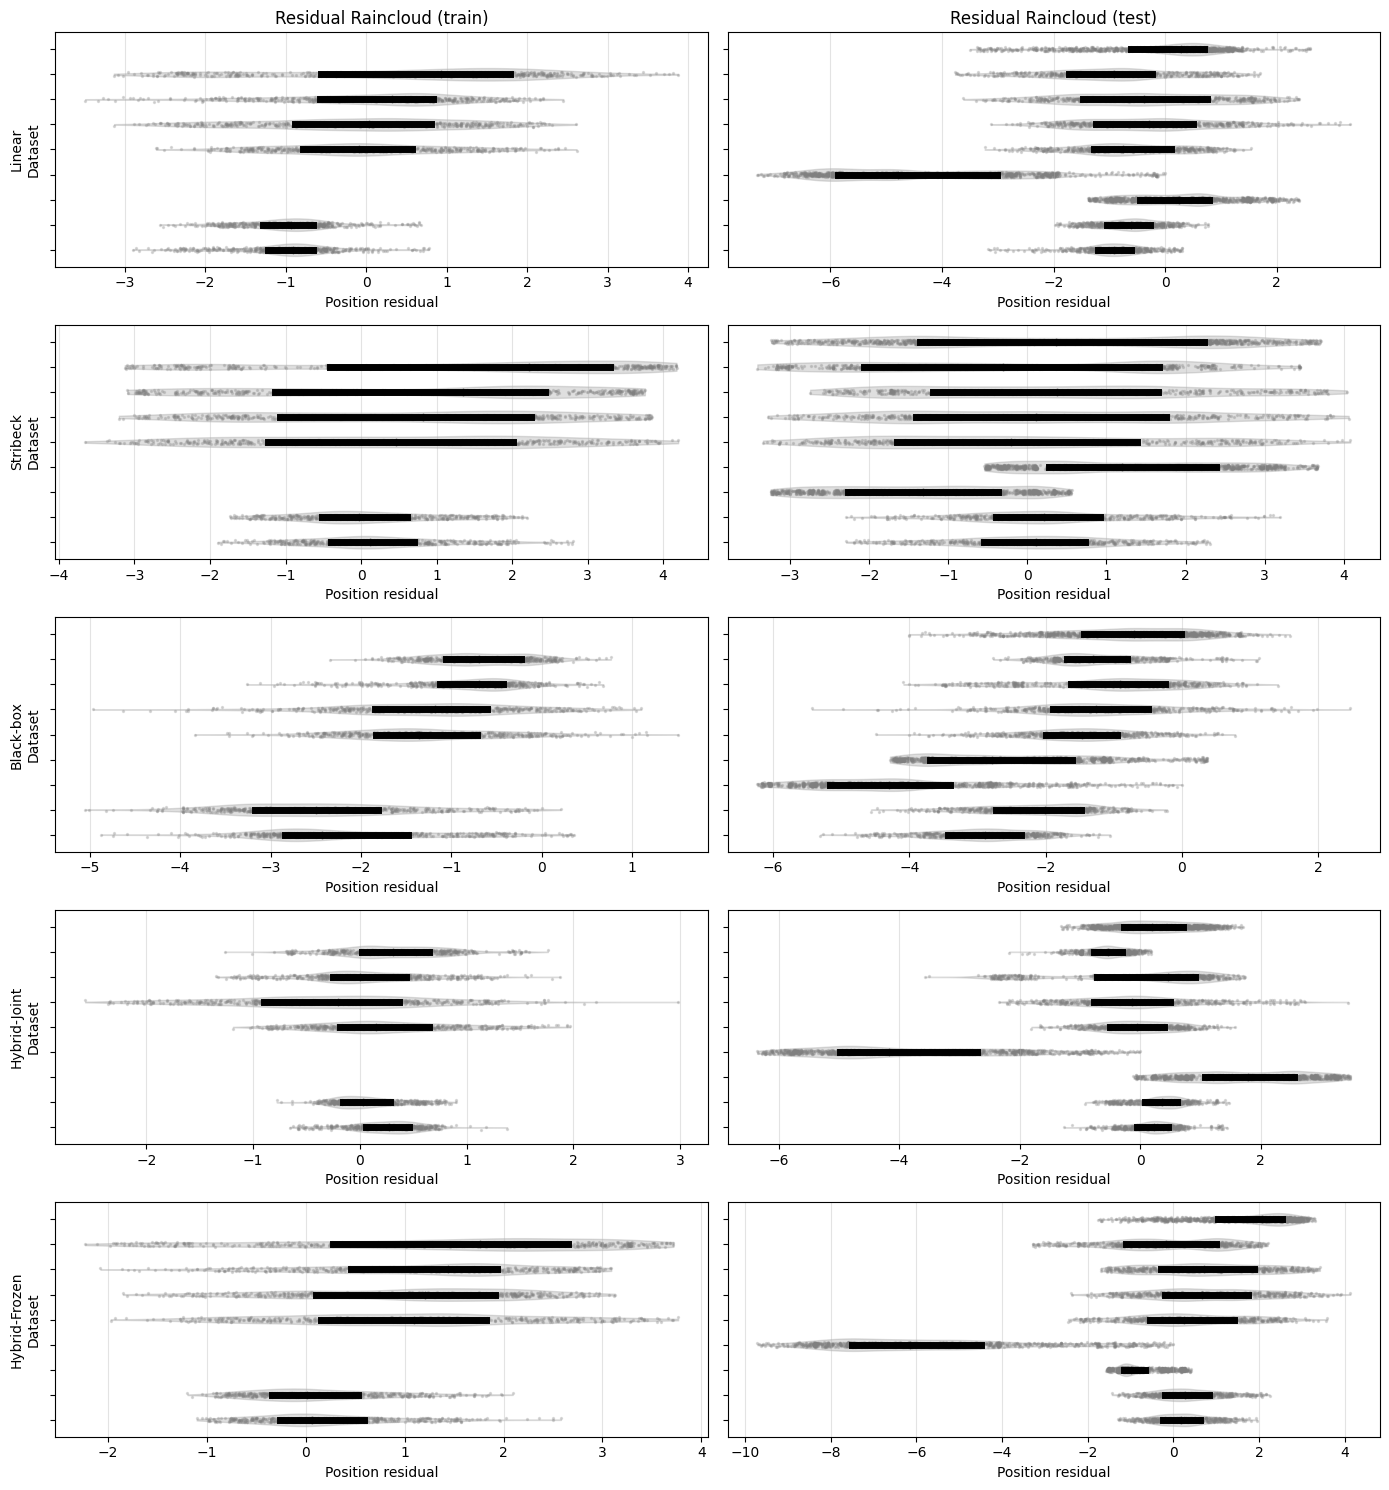

In [23]:
# Reuse protocol from training cell
print("Using PROTOCOL_MODE:", PROTOCOL_MODE)
print("Using TRAIN_DATASETS_CLASSIC:", TRAIN_DATASETS_CLASSIC)

# Evaluate all datasets with protocol, print R2 tables, and plot rainclouds:
# - rows = models
# - columns = train/test
# - each subplot y-axis = datasets

# =========================
# 1) Evaluation config
# =========================
PROTOCOL_MODE = "split_50_50"  # "split_50_50" or "classic_train_test"
TRAIN_DATASETS_CLASSIC = ["multisine_05"]

model_objects = {
    "Linear": lin_model,
    "Stribeck": str_model,
    "Black-box": bb_model,
    "Hybrid-Joint": hjoint_model,
    "Hybrid-Frozen": hfrozen_model,
}
model_names = list(model_objects.keys())

all_datasets = nod.list_experiments()
core_datasets = [d for d in all_datasets if ("multisine" in d or "random_steps" in d)]
external_datasets = [d for d in all_datasets if d not in core_datasets]

print(f"PROTOCOL_MODE: {PROTOCOL_MODE}")
print(f"Core datasets: {core_datasets}")
print(f"External datasets: {external_datasets}")

eval_store = {}

# =========================
# 2) Simulate all datasets
# =========================
for ds_name in all_datasets:
    data_ds = nod.load_experiment(
        ds_name,
        preprocess=True,
        plot=False,
        end_idx=None,
        resample_factor=50,
        zoom_last_n=200,
        y_dot_method=velMethod,
    )

    u_ds, y_ds, y_ref_ds, y_dot_ds = data_ds
    Ts_ds = data_ds.sampling_time
    t_ds = np.arange(len(u_ds)) * Ts_ds
    y_sim_ds = np.column_stack([y_ds, y_dot_ds])

    n = len(t_ds)
    split_i = int(0.5 * n)

    if PROTOCOL_MODE == "split_50_50":
        if ds_name in core_datasets:
            train_idx = np.arange(0, split_i)
            test_idx = np.arange(split_i, n)
        else:
            train_idx = None
            test_idx = np.arange(0, n)
    elif PROTOCOL_MODE == "classic_train_test":
        if ds_name in TRAIN_DATASETS_CLASSIC:
            train_idx = np.arange(0, n)
            test_idx = None
        else:
            train_idx = None
            test_idx = np.arange(0, n)
    else:
        raise ValueError(f"Unknown PROTOCOL_MODE: {PROTOCOL_MODE}")

    t_ds_tensor = torch.tensor(t_ds, dtype=torch.float32).to(device)
    u_ds_tensor = torch.tensor(u_ds, dtype=torch.float32).reshape(-1, 1).to(device)
    y_ds_tensor = torch.tensor(y_sim_ds, dtype=torch.float32).to(device)

    preds_ds = {}
    with torch.no_grad():
        x0_ds = y_ds_tensor[0].unsqueeze(0)
        for model_name, model_obj in model_objects.items():
            model_obj.u_series = u_ds_tensor
            model_obj.t_series = t_ds_tensor
            model_obj.batch_start_times = torch.zeros(1, 1).to(device)
            pred = odeint(model_obj, x0_ds, t_ds_tensor, method="rk4").squeeze(1).cpu().numpy()
            preds_ds[model_name] = pred

    metrics_ds = {m: {"train": None, "test": None} for m in model_names}
    residuals_ds = {m: {"train": None, "test": None} for m in model_names}

    for mname, pred in preds_ds.items():
        for split_name, idx in [("train", train_idx), ("test", test_idx)]:
            if idx is None or len(idx) < 2:
                continue

            y_true = y_sim_ds[idx]
            y_hat = pred[idx]
            res_pos = y_true[:, 0] - y_hat[:, 0]
            res_vel = y_true[:, 1] - y_hat[:, 1]

            rmse_pos = np.sqrt(np.mean(res_pos**2))
            rmse_vel = np.sqrt(np.mean(res_vel**2))

            ss_res_pos = np.sum(res_pos**2)
            ss_tot_pos = np.sum((y_true[:, 0] - np.mean(y_true[:, 0]))**2)
            ss_res_vel = np.sum(res_vel**2)
            ss_tot_vel = np.sum((y_true[:, 1] - np.mean(y_true[:, 1]))**2)

            r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
            r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan

            fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_true[:, 0] - np.mean(y_true[:, 0])))
            fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_true[:, 1] - np.mean(y_true[:, 1])))

            residuals_ds[mname][split_name] = {"pos": res_pos, "vel": res_vel}
            metrics_ds[mname][split_name] = {
                "rmse_pos": rmse_pos,
                "rmse_vel": rmse_vel,
                "r2_pos": r2_pos,
                "r2_vel": r2_vel,
                "fit_pos": fit_pos,
                "fit_vel": fit_vel,
            }

    eval_store[ds_name] = {
        "t": t_ds,
        "Ts": Ts_ds,
        "y_sim": y_sim_ds,
        "preds": preds_ds,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "metrics": metrics_ds,
        "residuals": residuals_ds,
    }

# =========================
# 3) R2 tables
# =========================
def print_r2_table(split_name, component):
    key = "r2_pos" if component == "pos" else "r2_vel"
    print(f"\nR2 table ({component}, {split_name})")
    header = "model".ljust(14) + " " + " ".join([d[:12].ljust(12) for d in all_datasets])
    print(header)
    for mname in model_names:
        vals = []
        for ds in all_datasets:
            m = eval_store[ds]["metrics"][mname][split_name]
            vals.append(np.nan if m is None else m[key])
        row = mname.ljust(14) + " " + " ".join(
            [("nan" if np.isnan(v) else f"{v:.4f}").ljust(12) for v in vals]
        )
        print(row)

print_r2_table("train", "pos")
print_r2_table("test", "pos")
print_r2_table("train", "vel")
print_r2_table("test", "vel")




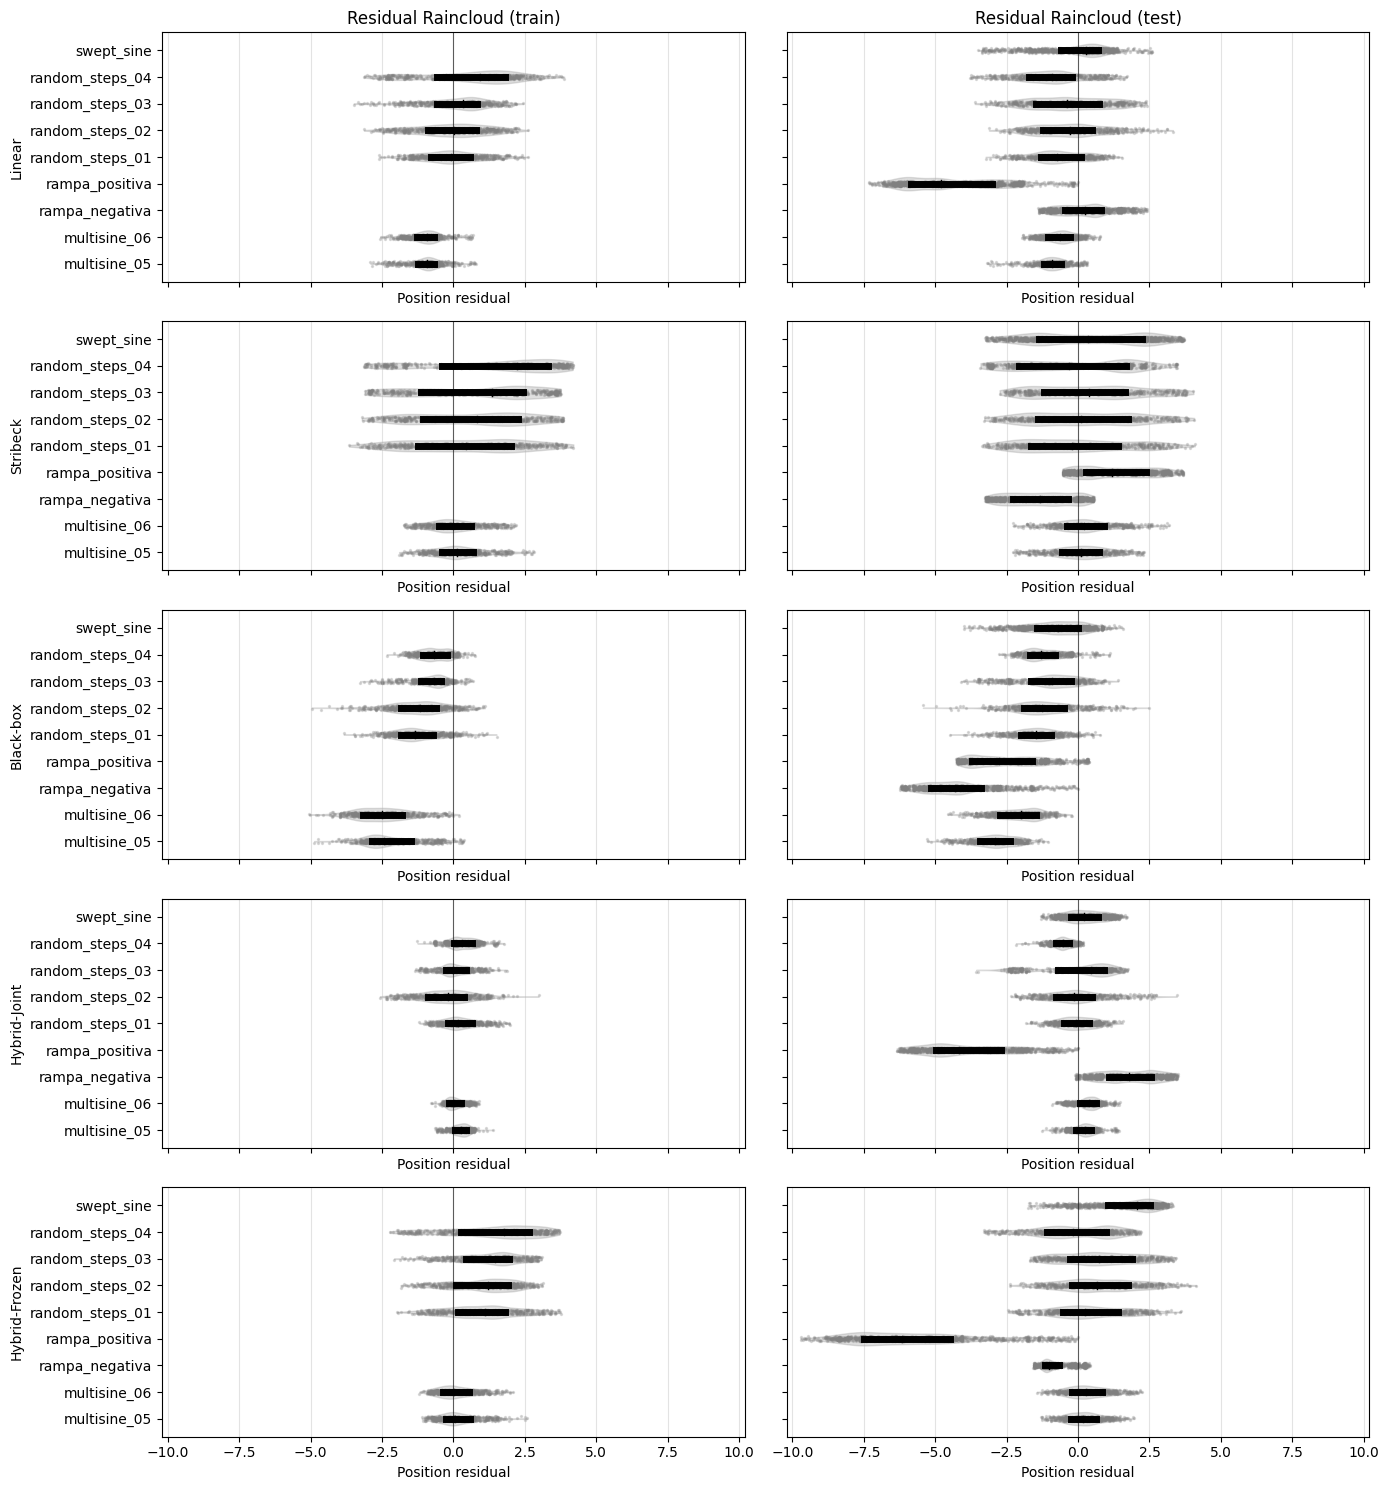

In [25]:
# =========================
# 4) Rainclouds
# rows = models, cols = [train, test], y-axis = datasets
# x-axis shared and centered at zero for all subplots
# =========================
splits = ["train", "test"]
n_models = len(model_names)
n_datasets = len(all_datasets)

# Global symmetric x-limits around zero across all models/datasets/splits
all_residuals = []
for mname in model_names:
    for split_name in splits:
        for ds in all_datasets:
            rpack = eval_store[ds]["residuals"][mname][split_name]
            if rpack is None:
                continue
            res = np.asarray(rpack["pos"])
            res = res[np.isfinite(res)]
            if len(res) > 0:
                all_residuals.append(res)

if len(all_residuals) == 0:
    raise RuntimeError("No residuals found for raincloud plotting.")

res_concat = np.concatenate(all_residuals)
x_abs = np.max(np.abs(res_concat))
pad = 0.05 * (x_abs + 1e-12)
xlim_shared = (-(x_abs + pad), (x_abs + pad))

fig, axes = plt.subplots(
    n_models, 2,
    figsize=(14, max(3.0 * n_models, 8)),
    sharex=True,
    sharey=True
)

if n_models == 1:
    axes = np.array([axes])

for r, mname in enumerate(model_names):
    model_label = mname.replace(" Dataset", "").replace("_Dataset", "")

    for c, split_name in enumerate(splits):
        ax = axes[r, c]

        for i, ds in enumerate(all_datasets):
            rpack = eval_store[ds]["residuals"][mname][split_name]
            if rpack is None:
                continue

            res = np.asarray(rpack["pos"])
            res = res[np.isfinite(res)]
            if len(res) < 5:
                continue

            # cloud
            xs = np.linspace(np.min(res), np.max(res), 200)
            kde = gaussian_kde(res)
            ys = kde(xs)
            ys = ys / ys.max() * 0.25
            ax.fill_between(xs, i + ys, i - ys, color="gray", alpha=0.25)

            # box-like summary
            q1, q2, q3 = np.percentile(res, [25, 50, 75])
            ax.plot([q1, q3], [i, i], color="black", linewidth=5)
            ax.plot([q2, q2], [i - 0.12, i + 0.12], color="black", linewidth=1)

            # rain
            jitter = (np.random.rand(len(res)) - 0.5) * 0.18
            ax.scatter(res, i + jitter, s=2, color="gray", alpha=0.25)

        if r == 0:
            ax.set_title(f"Residual Raincloud ({split_name})")

        if c == 0:
            ax.set_ylabel(model_label)
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Position residual")
        ax.grid(True, axis="x", alpha=0.35)
        ax.axvline(0.0, color="k", linewidth=0.8, alpha=0.6)

        # show dataset labels on every subplot
        ax.set_yticks(range(n_datasets))
        ax.set_yticklabels(all_datasets)

        # enforce shared symmetric limits
        ax.set_xlim(*xlim_shared)

plt.tight_layout()
plt.show()


## 14) Simulate All Models on Test Data

In [19]:
# Choose which test dataset to plot
plot_dataset = "swept_sine"  # change this to any dataset in test_datasets

if plot_dataset not in eval_store:
    raise ValueError(f"Dataset '{plot_dataset}' not found in eval_store. Available: {list(eval_store.keys())}")

t_test = eval_store[plot_dataset]["t"]
Ts_test = eval_store[plot_dataset]["Ts"]
y_sim_test = eval_store[plot_dataset]["y_sim"]
models_test = eval_store[plot_dataset]["preds"]
residuals_test = eval_store[plot_dataset]["residuals"]
metrics_test = eval_store[plot_dataset]["metrics"]

print(f"Selected dataset for plots: {plot_dataset}")


Selected dataset for plots: swept_sine


## 15) Test Comparison Plots and Metrics

In [20]:
# Choose which dataset and split to plot
plot_dataset = "random_steps_01"  # any key from eval_store
plot_split = "test"               # "train" or "test"

if plot_dataset not in eval_store:
    raise ValueError(f"Dataset '{plot_dataset}' not found. Available: {list(eval_store.keys())}")
if plot_split not in ["train", "test"]:
    raise ValueError("plot_split must be 'train' or 'test'")

idx = eval_store[plot_dataset][f"{plot_split}_idx"]
if idx is None or len(idx) < 2:
    raise ValueError(f"No '{plot_split}' samples for dataset '{plot_dataset}'")

base = eval_store[plot_dataset]
t_all = base["t"]
y_all = base["y_sim"]
models_all = base["preds"]
metrics_all = base["metrics"]
residuals_all = base["residuals"]
Ts_sel = base["Ts"]

t_sel = t_all[idx]
y_sel = y_all[idx]
models_sel = {name: pred[idx] for name, pred in models_all.items()}
residuals_sel = {name: residuals_all[name][plot_split] for name in models_all.keys()}
metrics_sel = {name: metrics_all[name][plot_split] for name in models_all.keys()}

print(f"Selected dataset: {plot_dataset} | split: {plot_split} | samples: {len(idx)}")


Selected dataset: random_steps_01 | split: test | samples: 551


Metrics - Position (random_steps_01, test)
Model          RMSE      R2        FIT%
Linear         1.1590    0.7822   53.33   
Stribeck       1.8274    0.4586   26.42   
Black-box      1.7146    0.5234   30.96   
Hybrid-Joint   0.6488    0.9318   73.88   
Hybrid-Frozen  1.2986    0.7266   47.71   

Metrics - Velocity (random_steps_01, test)
Model          RMSE      R2        FIT%
Linear         5.4430    0.9450   76.54   
Stribeck       15.3050   0.5649   34.03   
Black-box      23.4123   -0.0183  -0.91   
Hybrid-Joint   5.4953    0.9439   76.31   
Hybrid-Frozen  7.2992    0.9010   68.54   


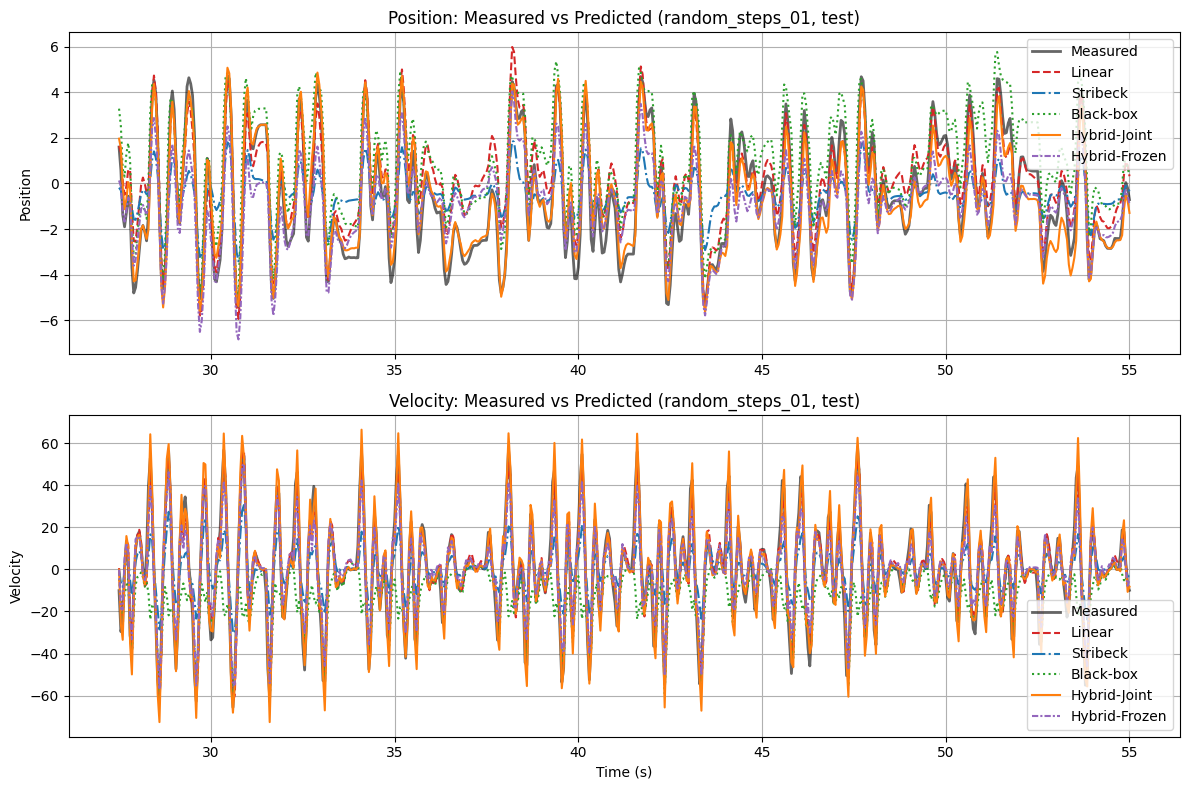

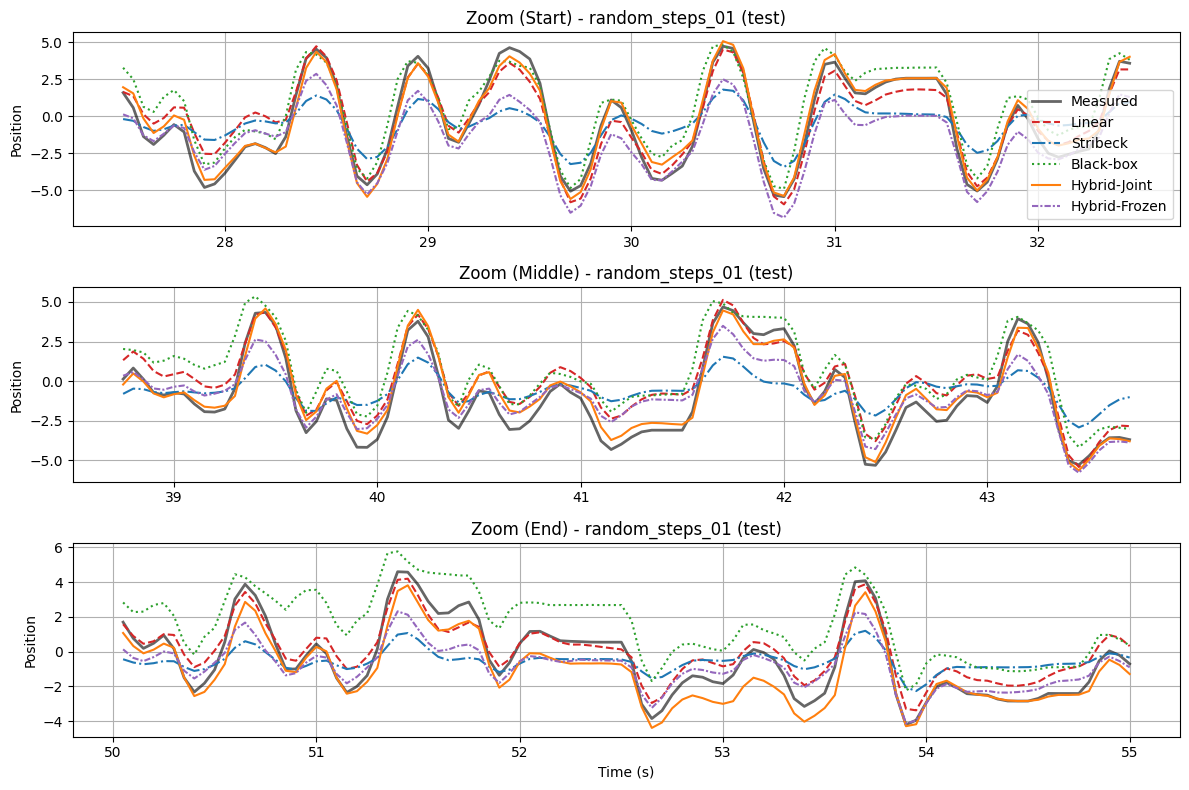

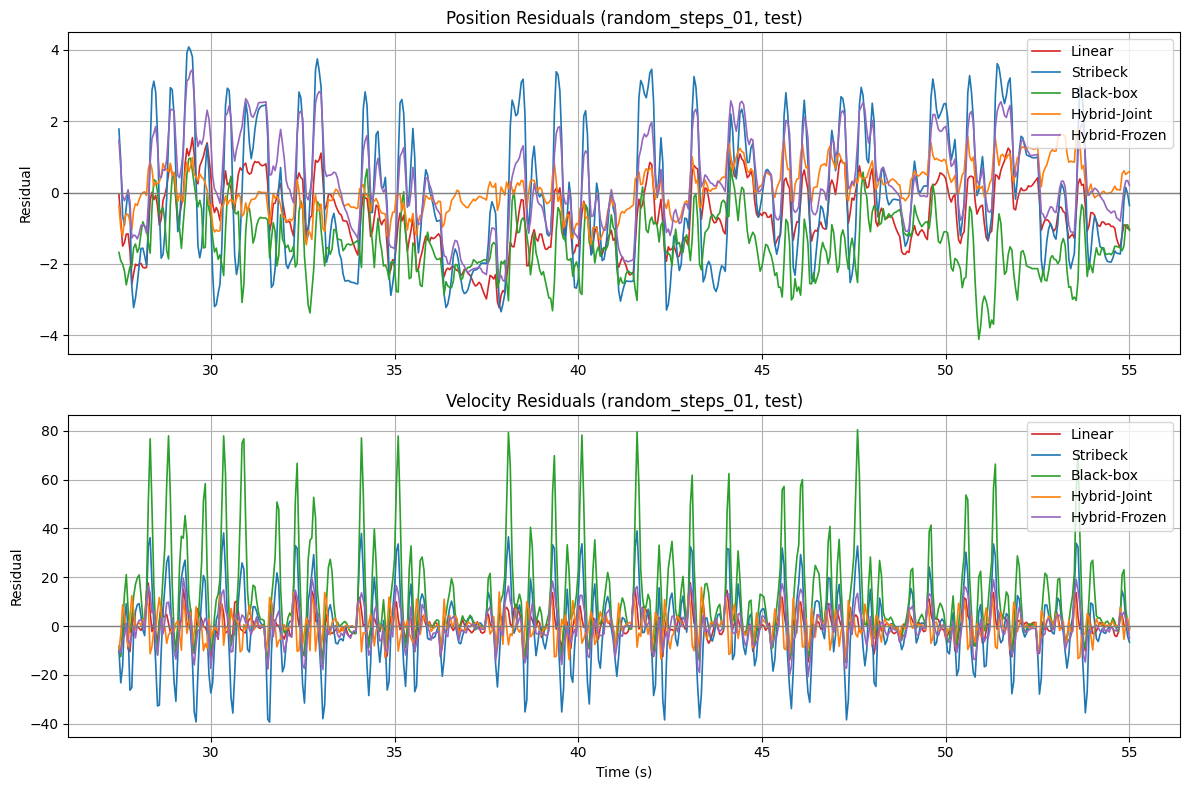

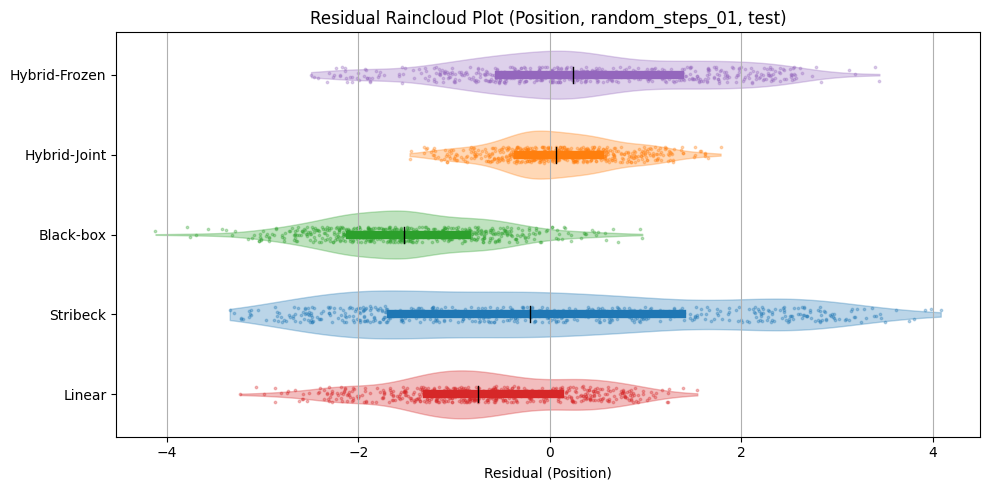

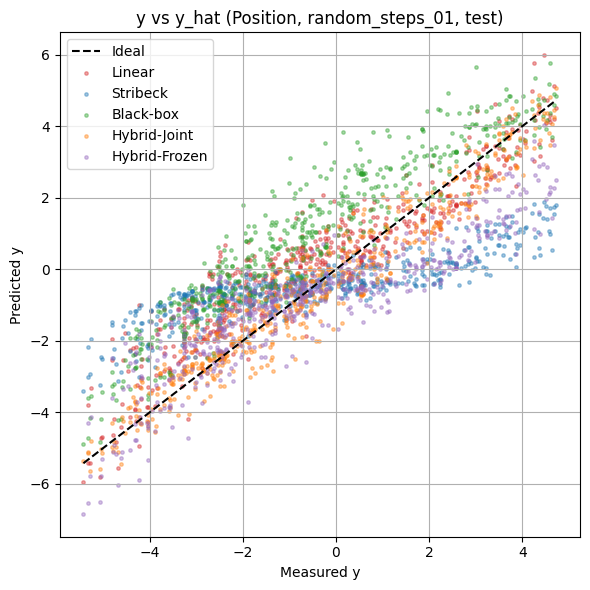

In [21]:
# Metrics tables for selected dataset/split
print(f"Metrics - Position ({plot_dataset}, {plot_split})")
print("Model          RMSE      R2        FIT%")
for name in models_sel.keys():
    m = metrics_sel[name]
    print(f"{name:<14} {m['rmse_pos']:<9.4f} {m['r2_pos']:<8.4f} {m['fit_pos']:<8.2f}")

print(f"\nMetrics - Velocity ({plot_dataset}, {plot_split})")
print("Model          RMSE      R2        FIT%")
for name in models_sel.keys():
    m = metrics_sel[name]
    print(f"{name:<14} {m['rmse_vel']:<9.4f} {m['r2_vel']:<8.4f} {m['fit_vel']:<8.2f}")

# Predictions vs measured
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_sel, y_sel[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models_sel.items():
    plt.plot(t_sel, pred[:, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.title(f"Position: Measured vs Predicted ({plot_dataset}, {plot_split})")

plt.subplot(2, 1, 2)
plt.plot(t_sel, y_sel[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models_sel.items():
    plt.plot(t_sel, pred[:, 1], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.title(f"Velocity: Measured vs Predicted ({plot_dataset}, {plot_split})")
plt.tight_layout()
plt.show()

# Zooms
win_sec = 5.0
win_n = int(win_sec / Ts_sel)
starts = [0, max(0, (len(t_sel) - win_n) // 2), max(0, len(t_sel) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(12, 8))
for i, s in enumerate(starts):
    e = min(len(t_sel), s + win_n)
    plt.subplot(3, 1, i + 1)
    plt.plot(t_sel[s:e], y_sel[s:e, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
    for name, pred in models_sel.items():
        plt.plot(t_sel[s:e], pred[s:e, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
    plt.title(f"Zoom ({labels[i]}) - {plot_dataset} ({plot_split})")
    plt.ylabel('Position')
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Residuals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for name in models_sel.keys():
    plt.plot(t_sel, residuals_sel[name]['pos'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Position Residuals ({plot_dataset}, {plot_split})')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
for name in models_sel.keys():
    plt.plot(t_sel, residuals_sel[name]['vel'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Velocity Residuals ({plot_dataset}, {plot_split})')
plt.ylabel('Residual')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Raincloud (position residuals)
from scipy.stats import gaussian_kde
labels_sel = list(models_sel.keys())
res_list_sel = [residuals_sel[name]['pos'] for name in labels_sel]

plt.figure(figsize=(10, 5))
for i, (label, res) in enumerate(zip(labels_sel, res_list_sel)):
    res = res[np.isfinite(res)]
    kde = gaussian_kde(res)
    xs = np.linspace(np.min(res), np.max(res), 200)
    ys = kde(xs)
    ys = ys / ys.max() * 0.3
    plt.fill_between(xs, i + ys, i - ys, color=colors[label], alpha=0.3)
    q1, q2, q3 = np.percentile(res, [25, 50, 75])
    plt.plot([q1, q3], [i, i], color=colors[label], linewidth=6)
    plt.plot([q2, q2], [i-0.1, i+0.1], color='k', linewidth=1)
    jitter = (np.random.rand(len(res)) - 0.5) * 0.2
    plt.scatter(res, i + jitter, s=3, color=colors[label], alpha=0.3)

plt.yticks(range(len(labels_sel)), labels_sel)
plt.xlabel('Residual (Position)')
plt.title(f'Residual Raincloud Plot (Position, {plot_dataset}, {plot_split})')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# y vs yhat
plt.figure(figsize=(6, 6))
plt.plot([y_sel[:,0].min(), y_sel[:,0].max()], [y_sel[:,0].min(), y_sel[:,0].max()], 'k--', label='Ideal')
for name, pred in models_sel.items():
    plt.scatter(y_sel[:,0], pred[:,0], s=6, alpha=0.4, color=colors[name], label=name)
plt.xlabel('Measured y')
plt.ylabel('Predicted y')
plt.title(f'y vs y_hat (Position, {plot_dataset}, {plot_split})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 16) Test Diagnostics (ACF and Spectra)

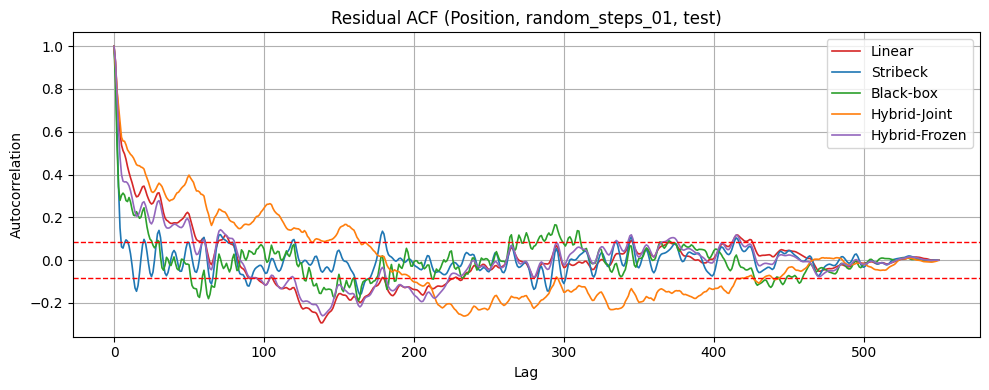

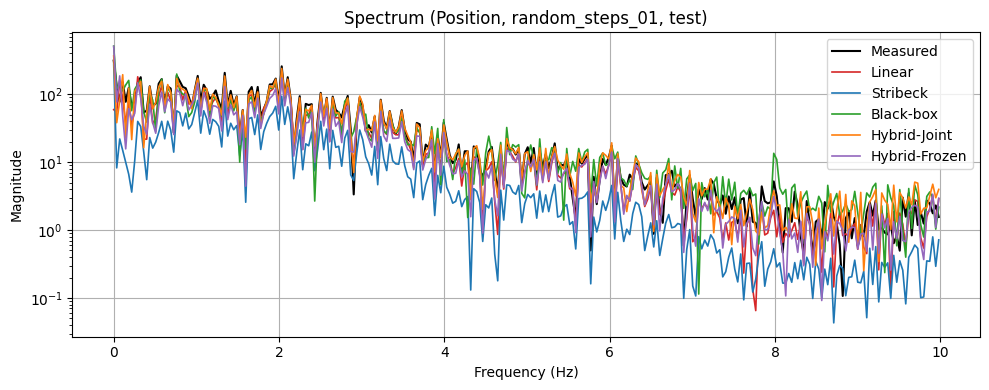

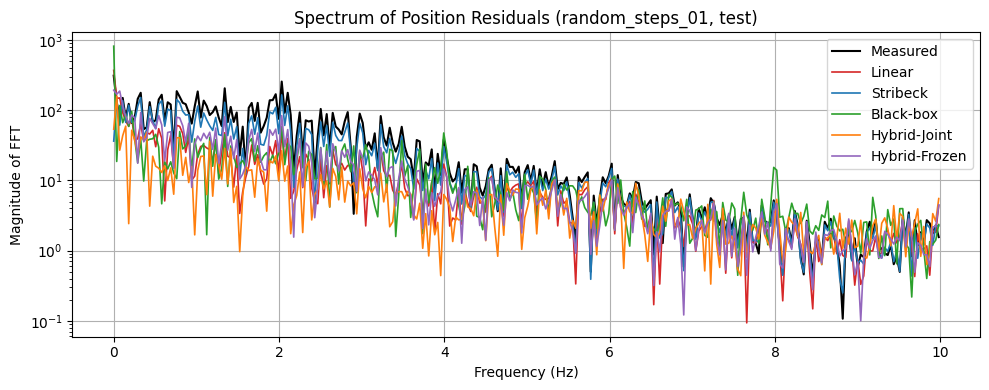

In [22]:
# ACF (position) for selected dataset/split
N_sel = len(t_sel)
max_lag_sel = min(2000, N_sel - 1)
conf_sel = 1.96 / np.sqrt(N_sel)

plt.figure(figsize=(10, 4))
for name in models_sel.keys():
    res = residuals_sel[name]['pos'] - np.mean(residuals_sel[name]['pos'])
    acf = np.correlate(res, res, mode='full')
    acf = acf[N_sel-1:N_sel+max_lag_sel] / acf[N_sel-1]
    plt.plot(np.arange(0, max_lag_sel + 1), acf, color=colors[name], linewidth=1.2, label=name)

plt.axhline(conf_sel, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf_sel, color='red', linestyle='--', linewidth=1)
plt.title(f'Residual ACF (Position, {plot_dataset}, {plot_split})')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum: measured vs predictions
freqs_sel = np.fft.rfftfreq(len(t_sel), d=Ts_sel)
Y_meas_sel = np.fft.rfft(y_sel[:, 0])

plt.figure(figsize=(10, 4))
plt.semilogy(freqs_sel, np.abs(Y_meas_sel), color='k', label='Measured')
for name, pred in models_sel.items():
    Y_pred = np.fft.rfft(pred[:, 0])
    plt.semilogy(freqs_sel, np.abs(Y_pred), color=colors[name], linewidth=1.2, label=name)
plt.title(f'Spectrum (Position, {plot_dataset}, {plot_split})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Residual spectrum
plt.figure(figsize=(10, 4))
plt.semilogy(freqs_sel, np.abs(Y_meas_sel), color='k', label='Measured')
for name in models_sel.keys():
    res_fft = np.fft.rfft(residuals_sel[name]['pos'])
    plt.semilogy(freqs_sel, np.abs(res_fft), color=colors[name], linewidth=1.2, label=name)
plt.title(f'Spectrum of Position Residuals ({plot_dataset}, {plot_split})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of FFT')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
